In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit, minimize
from joblib import Parallel, delayed
from numba import jit
import os

In [2]:
bobcat_df = pd.read_csv('cleaned_bobcat_data.csv')
rabbit_df = pd.read_csv('cleaned_rabbit_data.csv')

In [3]:
days = np.array(bobcat_df["# Day"])  # Time points
rabbits = np.array(rabbit_df[" Rabbits"])
bobcats = np.array(bobcat_df[" Bobcats"])

In [16]:
@jit(nopython=True)
def predator_prey(t, z, a, b, c, d):
    x, y = z  # x = Rabbits, y = Bobcats
    dxdt = a*x - b*x*y
    dydt = d*x*y - c*y
    return [dxdt, dydt]

def lotka_volterra_wrapper(t, z, a, b, c, d):
    return predator_prey(t, z, a, b, c, d)

In [ ]:
# Optimized single parameter fitting function
def optimize_single_params(days, rabbits, bobcats, initial_params):
    def objective_function(params):
        a, b, c, d = params
        
        solution = solve_ivp(
            lambda t, z: lotka_volterra_wrapper(t, z, a, b, c, d),
            [days[0], days[-1]],
            [rabbits[0], bobcats[0]],
            method='LSODA',  # Often faster for biological systems
            t_eval=days,
            rtol=1e-3,       # Relaxed tolerance for speed
            atol=1e-6
        )
        
        # Calculate normalized error
        rabbit_error = np.sum((rabbits - solution.y[0])**2) / np.mean(rabbits)**2
        bobcat_error = np.sum((bobcats - solution.y[1])**2) / np.mean(bobcats)**2
        
        return rabbit_error + bobcat_error
    
    # Use efficient optimizer
    result = minimize(
        objective_function,
        initial_params,
        method='L-BFGS-B',
        bounds=[(0.001, 5), (0.0001, 1), (0.001, 5), (0.0001, 1)],
        options={'maxiter': 100, 'ftol': 1e-5}
    )
    
    return {'params': result.x, 'error': result.fun}

In [12]:
# Generate different initial parameter guesses
def generate_initial_params(days, rabbits, bobcats, index):
    # Base calculation
    if len(rabbits) > 2 and len(bobcats) > 2:
        try:
            # Estimate growth rates from data
            rabbit_growth = np.clip(np.mean(np.diff(rabbits)/rabbits[:-1]), 0.01, 2.0)
            bobcat_decline = np.clip(np.mean(np.diff(bobcats)/bobcats[:-1]), -2.0, -0.01)
            
            # Add some randomness for different starting points
            np.random.seed(index)
            return [
                np.abs(rabbit_growth) * (0.5 + np.random.rand()),
                0.01 * (0.5 + np.random.rand()),
                np.abs(bobcat_decline) * (0.5 + np.random.rand()),
                0.01 * (0.5 + np.random.rand())
            ]
        except:
            # Fallback to defaults with some randomization
            np.random.seed(index)
            return [0.5, 0.02, 0.5, 0.02] * (0.5 + np.random.rand(4))
    else:
        # Default parameters with randomization
        np.random.seed(index)
        return [0.5, 0.02, 0.5, 0.02] * (0.5 + np.random.rand(4))

In [13]:
# Main parallel fitting function
def fit_lotka_volterra(days, rabbits, bobcats, num_trials=10):
    # Determine number of cores to use
    n_jobs = max(1, os.cpu_count() - 1)  # Leave one core free
    
    # Generate multiple starting points
    initial_params_list = [generate_initial_params(days, rabbits, bobcats, i) for i in range(num_trials)]
    
    # Run optimizations in parallel
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(optimize_single_params)(days, rabbits, bobcats, params) 
        for params in initial_params_list
    )
    
    # Find the best result
    best_idx = np.argmin([res['error'] for res in results])
    
    return results[best_idx]['params']  # a, b, c, d

In [17]:
a, b, c, d = fit_lotka_volterra(days, rabbits, bobcats)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   8 out of  10 | elapsed:    6.5s remaining:    1.6s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    7.7s finished


In [18]:
future_days = np.arange(days[-1], days[-1] + 90)
sol = solve_ivp(predator_prey, [days[-1], future_days[-1]], [rabbits[-1], bobcats[-1]], args=(a, b, c, d), t_eval=future_days)

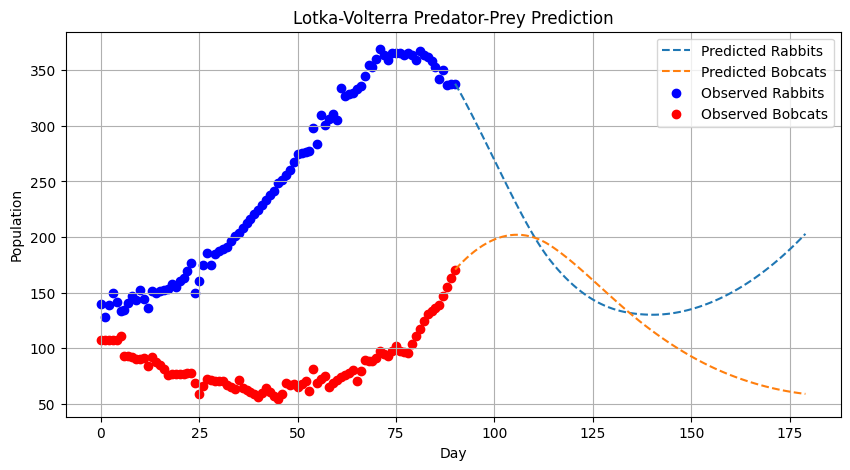

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(future_days, sol.y[0], label="Predicted Rabbits", linestyle="--")
plt.plot(future_days, sol.y[1], label="Predicted Bobcats", linestyle="--")
plt.scatter(days, rabbits, label="Observed Rabbits", color="blue")
plt.scatter(days, bobcats, label="Observed Bobcats", color="red")
plt.xlabel("Day")
plt.ylabel("Population")
plt.title("Lotka-Volterra Predator-Prey Prediction")
plt.legend()
plt.grid()
plt.show()

Rabbit RMSE: 7.01, R²: 0.9931
Bobcat RMSE: 5.64, R²: 0.9484


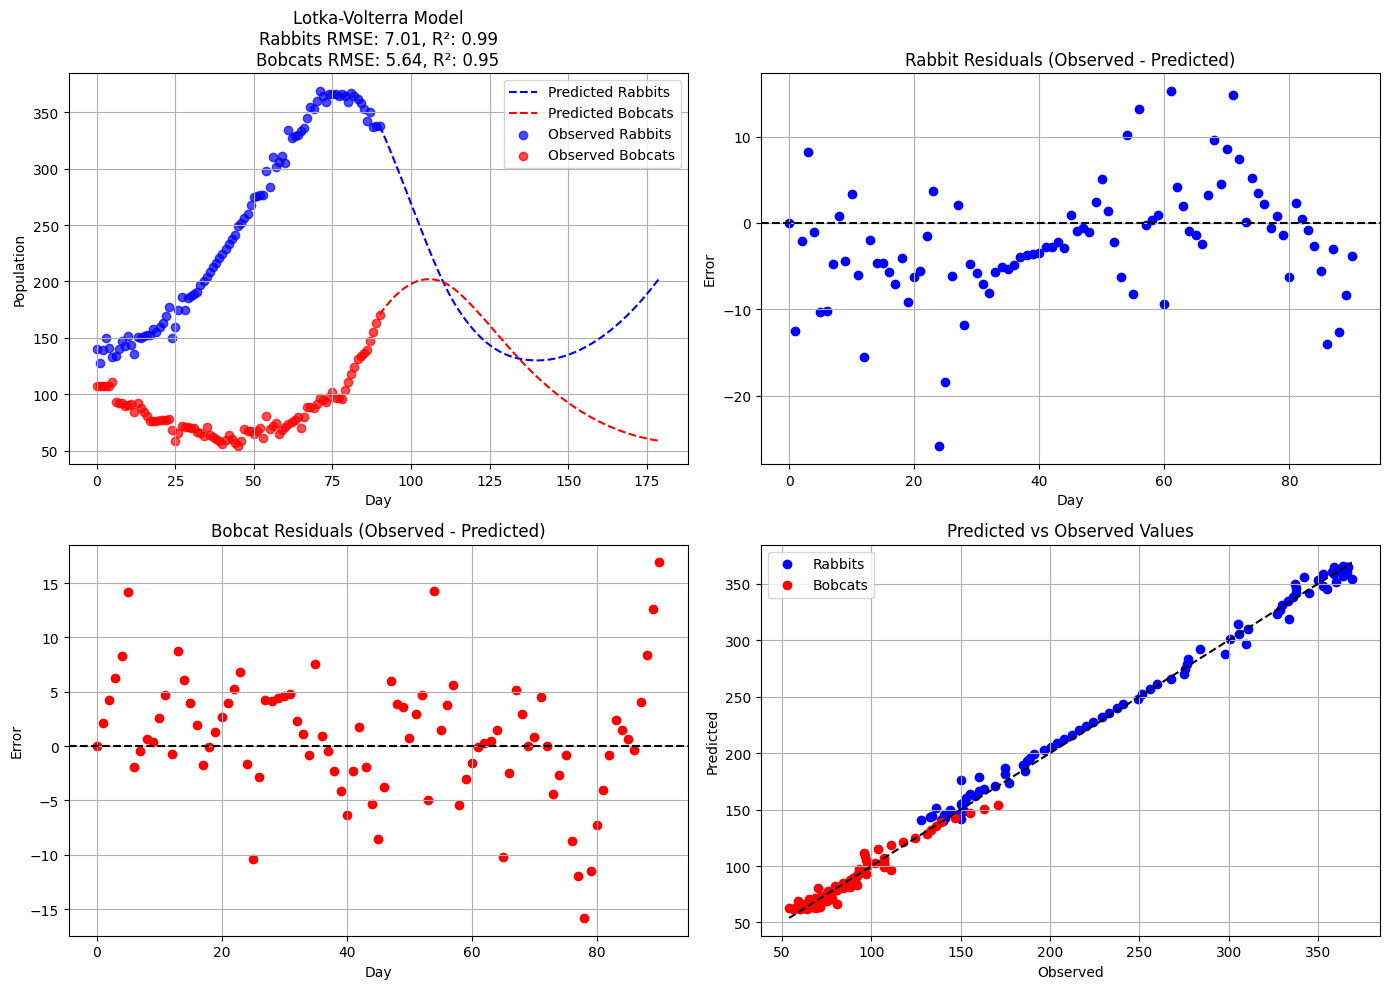

In [20]:
# First get predictions for the original days (not future predictions)
sol_fitted = solve_ivp(
    lambda t, z: lotka_volterra_wrapper(t, z, a, b, c, d),
    [days[0], days[-1]],
    [rabbits[0], bobcats[0]],
    method='LSODA',
    t_eval=days
)

rabbits_pred = sol_fitted.y[0]
bobcats_pred = sol_fitted.y[1]

# Calculate error metrics
rabbit_rmse = np.sqrt(np.mean((rabbits - rabbits_pred)**2))
bobcat_rmse = np.sqrt(np.mean((bobcats - bobcats_pred)**2))

# Calculate R-squared
rabbit_ss_total = np.sum((rabbits - np.mean(rabbits))**2)
bobcat_ss_total = np.sum((bobcats - np.mean(bobcats))**2)
rabbit_ss_res = np.sum((rabbits - rabbits_pred)**2)
bobcat_ss_res = np.sum((bobcats - bobcats_pred)**2)
rabbit_r2 = 1 - (rabbit_ss_res / rabbit_ss_total)
bobcat_r2 = 1 - (bobcat_ss_res / bobcat_ss_total)

# Print error metrics
print(f"Rabbit RMSE: {rabbit_rmse:.2f}, R²: {rabbit_r2:.4f}")
print(f"Bobcat RMSE: {bobcat_rmse:.2f}, R²: {bobcat_r2:.4f}")

# Create visualization of error
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Model fit with predictions
axs[0, 0].plot(future_days, sol.y[0], 'b--', label="Predicted Rabbits")
axs[0, 0].plot(future_days, sol.y[1], 'r--', label="Predicted Bobcats")
axs[0, 0].scatter(days, rabbits, label="Observed Rabbits", color="blue", alpha=0.7)
axs[0, 0].scatter(days, bobcats, label="Observed Bobcats", color="red", alpha=0.7)
axs[0, 0].set_title(f"Lotka-Volterra Model\nRabbits RMSE: {rabbit_rmse:.2f}, R²: {rabbit_r2:.2f}\nBobcats RMSE: {bobcat_rmse:.2f}, R²: {bobcat_r2:.2f}")
axs[0, 0].set_xlabel("Day")
axs[0, 0].set_ylabel("Population")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residuals over time for rabbits
axs[0, 1].scatter(days, rabbits - rabbits_pred, color="blue")
axs[0, 1].axhline(y=0, color='k', linestyle='--')
axs[0, 1].set_title("Rabbit Residuals (Observed - Predicted)")
axs[0, 1].set_xlabel("Day")
axs[0, 1].set_ylabel("Error")
axs[0, 1].grid(True)

# Plot 3: Residuals over time for bobcats
axs[1, 0].scatter(days, bobcats - bobcats_pred, color="red")
axs[1, 0].axhline(y=0, color='k', linestyle='--')
axs[1, 0].set_title("Bobcat Residuals (Observed - Predicted)")
axs[1, 0].set_xlabel("Day")
axs[1, 0].set_ylabel("Error")
axs[1, 0].grid(True)

# Plot 4: Predicted vs Observed values
axs[1, 1].scatter(rabbits, rabbits_pred, color="blue", label="Rabbits")
axs[1, 1].scatter(bobcats, bobcats_pred, color="red", label="Bobcats")
# Add diagonal line for perfect predictions
max_val = max(np.max(rabbits), np.max(bobcats), np.max(rabbits_pred), np.max(bobcats_pred))
min_val = min(np.min(rabbits), np.min(bobcats), np.min(rabbits_pred), np.min(bobcats_pred))
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--')
axs[1, 1].set_title("Predicted vs Observed Values")
axs[1, 1].set_xlabel("Observed")
axs[1, 1].set_ylabel("Predicted")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()